Example inspired by tinyGP example on Deep GP: https://tinygp.readthedocs.io/en/stable/tutorials/transforms.html

In [150]:
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import pyro
import pyro.contrib.gp as gp
import pyro.infer as infer
import seaborn as sns

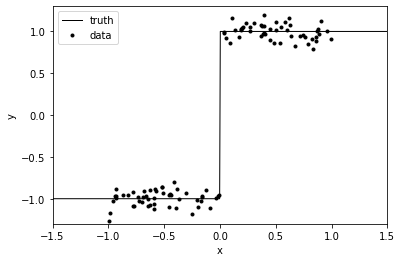

In [135]:
torch.manual_seed(0)

noise = 0.1

x = torch.sort(torch.distributions.Uniform(low=-1., high=1.).sample([100, 1]), 0)[0]
x_squeeze = x.squeeze()
y = 2 * (x_squeeze > 0) - 1 + torch.distributions.Normal(loc=0.0, scale=noise).sample([len(x)])
t =torch.linspace(-1.5, 1.5, 500)

plt.plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
plt.plot(x_squeeze, y, ".k", label="data")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

In [152]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [153]:
n = Net()
rbf = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))
deep_kernel = gp.kernels.Warping(rbf, iwarping_fn=n)
likelihood = gp.likelihoods.Gaussian()
model_deep = gp.models.VariationalGP(
    X=x,
    y=y,
    kernel=deep_kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=2e-3,
)

model_rbf = gp.models.VariationalGP(
    X=x,
    y=y,
    kernel=gp.kernels.RBF(input_dim=1),
    likelihood=likelihood,
    whiten=True,
    jitter=2e-3,
)

In [154]:
losses_deep = gp.util.train(model_deep, num_steps=500)
losses_rbf = gp.util.train(model_rbf, num_steps=500)

Text(0, 0.5, 'Loss')

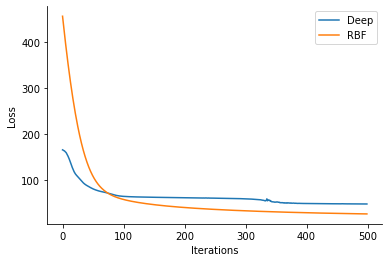

In [157]:
plt.plot(losses_deep, label='Deep')
plt.plot(losses_rbf, label='RBF')
sns.despine()
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")

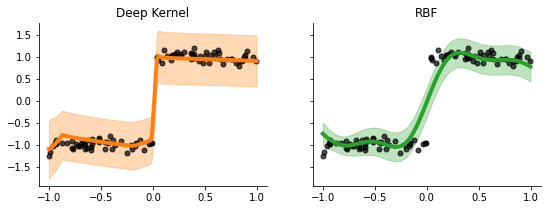

In [158]:
with torch.no_grad():
    fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(9, 3))
    for i, (model_name, model) in enumerate(zip(["Deep Kernel", "RBF"], [model_deep, model_rbf])):
        mean, var = model(x)
        ax[i].plot(x.squeeze(), mean, lw=4, color=f'C{i+1}', label=model_name)
        ax[i].fill_between(x_squeeze, mean-torch.sqrt(var), mean+torch.sqrt(var), alpha=0.3, color=f'C{i+1}')
        ax[i].scatter(x.squeeze(), y, color='k', alpha=0.7, s=25)
        ax[i].set_title(model_name)
sns.despine()